In [346]:
from numpy import genfromtxt
import numpy as np
import math
from pylab import *
import urllib
import os
import matplotlib.pyplot as pl
import pandas as pd
from sklearn.metrics import mean_squared_error
from __future__ import division
from scipy.optimize import curve_fit
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from lmfit import Model
pl.style.use('seaborn')
pl.rc('font',family='Arial')

### constants

In [905]:
temp = 300.
Ms = 420000.
kb = 1.381e-23 
tau0 = 1e-12
K = 5000.
mu0 = 4*np.pi*1e-7

In [1159]:
def visc_calc(T, mass_fraction):
    glycerolDen = (1273.3-0.6121*T)/1000 			#Density of Glycerol (g/cm3)
    waterDen = (1-math.pow(((abs(T-4))/622),1.7)) 	#Density of water (g/cm3)
    
    ##Andreas Volk polynomial method
    contraction_av = 1-math.pow(3.520E-8*((mass_fraction*100)),3)+math.pow(1.027E-6*((mass_fraction*100)),2)+2.5E-4*(mass_fraction*100)-1.691E-4
    contraction = 1+contraction_av/100
    
    glycerolVisc=0.001*12100*np.exp((-1233+T)*T/(9900+70*T))
    waterVisc=0.001*1.790*np.exp((-1230-T)*T/(36100+360*T))
    
    a=0.705-0.0017*T
    b=(4.9+0.036*T)*np.power(a,2.5)
    alpha=1-mass_fraction+(a*b*mass_fraction*(1-mass_fraction))/(a*mass_fraction+b*(1-mass_fraction))
    A=np.log(waterVisc/glycerolVisc)
    
    viscosity_mix=glycerolVisc*np.exp(A*alpha)
    
    return viscosity_mix

def power(my_list, p):
    return [ x**p for x in my_list ]

def calc_neel(size, k):
    neel = []
    for x in range(len(size)):
        neel.append(tau0*np.exp(k[x]*4*np.pi*(1e-9*float(size[x]))**3*(24*kb*temp)**(-1)))
    return neel

def calc_brown(eta, hsize):
    brown = []
    for x in range(len(eta)):
        brown.append(eta[x]*np.pi*(hsize[x]*1e-9)**3*(2*kb*temp)**(-1))
    return brown

def vol(my_list):
    return[ np.pi*(1e-9*x)**3/6. for x in my_list ]


### import data to data frame

In [1070]:
freqs = []
fields = []
size = []
sigma = []
g = []
m = []
third = []
fifth = []
label = []
hsize = []
#phase1 = []
#phase3 = []
hlabel = []
eta = []
Dfifth = []
Dthird = [] 
ms = []

for f in os.listdir('MPS-march'):
    if f[-5] == "F":
        filename = 'MPS-march/' + f
        s = str.split(f,"-")
        if s[0][:-3] == "40":
            freqs.append(40200)
        elif s[0][:-3] == "25" or s[0][:-3] == "26":
            freqs.append(25250)
        elif s[0][:-3] == "15":
            freqs.append(15500)
        filedata = np.genfromtxt(filename, delimiter=',')
        fields.append(abs(filedata[1,0]))
        if s[2][:-2] == "25":
            size.append(25.2)
            sigma.append(0.09)
            hsize.append(90.)
            ms.append(370000.)
        elif s[2][:-2] == "28":
            size.append(27.7)
            sigma.append(0.1)
            hsize.append(75.)
            ms.append(390000.)
        elif s[2][:-2] == "22":
            size.append(21.9)
            sigma.append(0.05)
            hsize.append(90.)
            ms.append(350000.)
        if s[3][0] == "g":
            g.append(int(s[3][1:]))
            eta.append(visc_calc(25, int(s[3][1:])*0.01*135/150.))
            m.append(None)
            label.append('g')
        elif s[3][0] == "m":
            m.append(int(s[3][1:]))
            g.append(None)
            eta.append(None)
            label.append('m')
        hlabel.append(s[1][:-2])
        moment = np.append(filedata[1:,1], filedata[1:,4])
        third.append(abs(np.fft.fft(moment)[3]))
        fifth.append(abs(np.fft.fft(moment)[5]))
        #phase1.append(np.angle(np.fft.fft(moment)[1]))
        #phase3.append(np.angle(np.fft.fft(moment)[3]))
        datfile = "MPS-march/"+ s[0] + "-" + s[1] + "-" + s[2] + "-" + s[3] + "-_MPS_dat.csv"
        datfiledata = np.genfromtxt(datfile, delimiter=',',invalid_raise=False,missing_values='')[1:,:]
        Dthird.append(datfiledata[1,15])
        Dfifth.append(datfiledata[2,15])
        
data = pd.DataFrame({'frequency': freqs, 'field': fields,'size': size, 'sigma': sigma, \
                     'viscosity': g, 'mannitol': m, 'third': third, 'fifth': fifth, 'label': label, 'hsize': hsize, \
                     'hlabel': hlabel, 'eta': eta, 'dthird': Dthird, 'dfifth': Dfifth, 'Ms': ms})

data['5:3'] = data['fifth']/data['third']
data['D5:3'] = data['dfifth']/data['dthird']
data['angF'] = 2*np.pi*data['frequency']
#data['rTime1'] = np.tan(data['phase1']/data['angF'])
#data['rTime3'] = np.tan(data['phase3']/data['angF'])
data['tauB'] = data['eta']*np.pi*(power(1e-9*data['hsize'], 3))*(2*kb*temp)**(-1)
data['tauN'] = calc_neel(data['size'])
data['Vc'] = vol(data['size'])

/Users/shasha/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:63: ConversionWarning: Some errors were detected !
    Line #14 (got 14 columns instead of 24)
    Line #15 (got 14 columns instead of 24)
    Line #16 (got 14 columns instead of 24)
    Line #17 (got 14 columns instead of 24)
    Line #18 (got 14 columns instead of 24)
    Line #19 (got 14 columns instead of 24)
    Line #20 (got 14 columns instead of 24)
    Line #21 (got 14 columns instead of 24)
    Line #22 (got 14 columns instead of 24)
    Line #23 (got 14 columns instead of 24)
    Line #24 (got 14 columns instead of 24)
    Line #25 (got 14 columns instead of 24)
    Line #26 (got 14 columns instead of 24)
    Line #27 (got 14 columns instead of 24)
/Users/shasha/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:63: ConversionWarning: Some errors were detected !
    Line #34 (got 14 columns instead of 24)
    Line #35 (got 14 columns instead of 24)
    Line #36 (got 14 columns instead of 24)


### calculate Langevin harmonics

In [1071]:
for index, row in data.iterrows():
    T = row['frequency']**(-1)
    t = np.arange(0,T,T/1000.)
    H = 0.001*row['field']*np.cos(row['angF']*t)
    V = (4/3)*np.pi*(row['size']*1e-9/2)**3
    xi = Ms*V*H/(kb*temp)
    L = np.cosh(xi)/np.sinh(xi) - 1/xi
    data.loc[index,'L5:3'] = abs(np.fft.fft(L)[5])/abs(np.fft.fft(L)[3])
    

## import simulation data

In [1164]:
freqs = []
fields = []
size = []
third = []
fifth = []
hsize = []
sigma = []
eta = []
b = []
K = []

for f in os.listdir('fits'):
    if f[-1] == 'v':
        filename = 'fits/' + f
        filedata = np.genfromtxt(filename, delimiter=',')
        f = f[:-4]
        s = str.split(f,"_")
        size.append(float(s[0][:-2]))
        fields.append(float(s[1][:-2]))
        freqs.append(int(s[2][:-3])*1000)
        hsize.append(50.)
        sigma.append(0.1)
        eta.append(8.9e-4)
        moment = filedata[:,1]
        third.append(abs(np.fft.fft(moment)[3]))
        fifth.append(abs(np.fft.fft(moment)[5]))
        if s[-1] == "frozen":
            b.append("off")
            if len(s) == 4:
                K.append(5000.)
        else:
            b.append("on")
            if len(s) == 3:
                K.append(5000.)
            else:
                K.append(1000*float(s[3][1:]))
        
            
        
sdata = pd.DataFrame({'frequency': freqs, 'field': fields,'size': size, 'sigma': sigma, \
                     'third': third, 'fifth': fifth, 'hsize': hsize, 'eta': eta, 'b': b, 'K': K})

sdata['5:3'] = sdata['fifth']/sdata['third']
sdata['angF'] = 2*np.pi*sdata['frequency']
sdata['Vc'] = vol(sdata['size'])
sdata['Ms'] = 393023 * (1 - np.exp(-2.78258e8 * sdata['size']*1e-9))**57.87571 
sdata['tauB'] = calc_brown(sdata['eta'],sdata['hsize'])
sdata['tauN'] = calc_neel(sdata['size'], sdata['K'])

In [1165]:
for index, row in sdata.iterrows():
    T = row['frequency']**(-1)
    t = np.arange(0,T,T/1000.)
    H = 0.001*row['field']*np.cos(row['angF']*t)
    V = (4/3)*np.pi*(row['size']*1e-9/2)**3
    xi = row['Ms']*V*H/(kb*temp)
    L = np.cosh(xi)/np.sinh(xi) - 1/xi
    sdata.loc[index,'L5:3'] = abs(np.fft.fft(L)[5])/abs(np.fft.fft(L)[3])

### test plotting

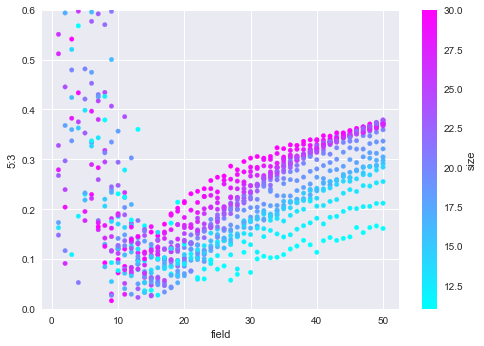

In [1170]:
pl.figure()
cmap = cm.get_cmap('cool')
sdata[(sdata['frequency'] == 25000) & (sdata['K'] == 20000)].plot.scatter(x='field', y='5:3', c='size',sharex=False, cmap=cmap)
ylim(0,0.6)
pl.show()

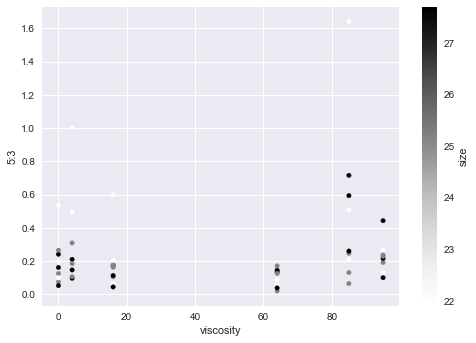

In [225]:
pl.figure()
cmap = cm.get_cmap('cool')
data[(data['field'] > 1) & (data['field'] < 6) \
     & (data['label'] == "g")].plot.scatter(x='viscosity', y='5:3', c='size',sharex=False)
pl.show()

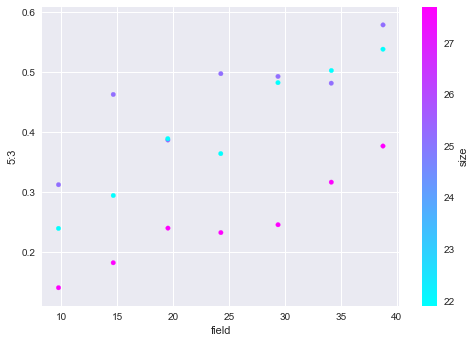

In [337]:
pl.figure()
cmap = cm.get_cmap('cool')
trimdata[(trimdata['viscosity'] == 85.0) \
    & (trimdata['frequency'] == 15500)].plot.scatter(x='field', y='5:3', c='size',cmap=cmap,sharex=False)
pl.show()

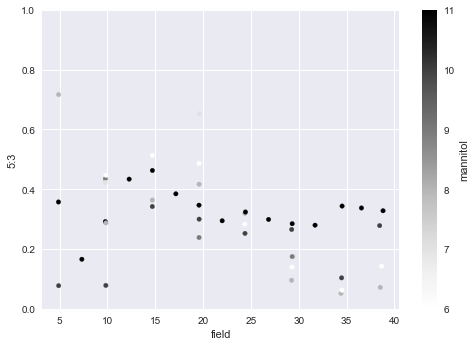

In [107]:
pl.figure()
data[(data['size'] == 25.2) & (data['label'] == 'm') \
     & (data['frequency'] == 25250)].plot.scatter(x='field', y='5:3', c='mannitol', sharex=False)
pl.ylim(0,1)
pl.show()

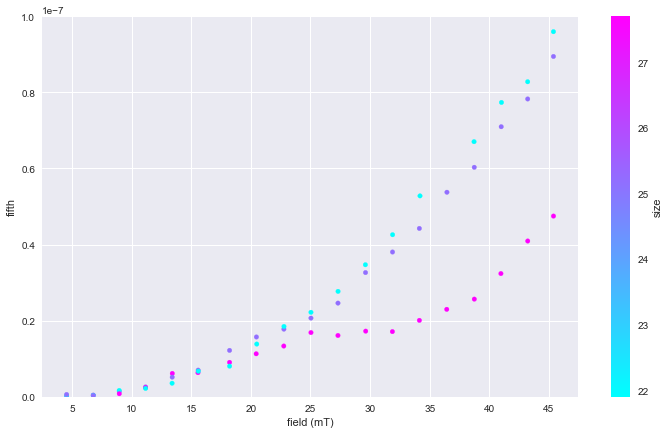

In [692]:
#pl.figure()
cmap = cm.get_cmap('cool')
ax = data[(data['mannitol'] == 11.0) & (data['frequency'] == 40200)].plot(kind="scatter", \
    x='field', y='fifth', c='size',figsize=(12,7),cmap=cmap,sharex=False)
ax.set_xlabel('field (mT)')
ylim(0,.0000001)
show()

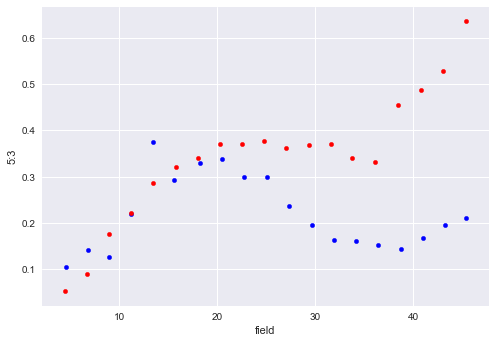

In [742]:
#pl.figure()

d1 = data[(data['mannitol'] == 11.0) & (data['frequency'] == 40200) & (data['size'] == 27.7)]
d2 = data[(data['viscosity'] == 0.0) & (data['frequency'] == 40200) & (data['size'] == 27.7)]

d1 = d1.sort_values(by=['field'])
d2 = d2.sort_values(by=['field'])

ax = d1.plot(x='field', y='5:3', kind='scatter', c='b')
d2.plot(ax=ax, x='field', y='5:3', kind='scatter', c='r')
#ylim(0,.0000004)

#data[(data['mannitol'] == 11.0) & (data['frequency'] == 40200) & (data['size'] == 21.9)].plot(kind="scatter", \
#    x='field', y='5:3', figsize=(12,7))

#data[(data['viscosity'] == 0.0) & (data['frequency'] == 40200)& (data['size'] == 21.9) ].plot(kind="scatter", \
#    x='field', y='5:3', figsize=(12,7))

#ax.set_xlabel('field (mT)')
#ylim(0,.0000001)
show()

In [1166]:
print(sdata)

             K    b      eta  field      fifth  frequency  hsize  sigma  size  \
0       5000.0  off  0.00089   25.0   6.303633      10000   50.0    0.1  17.0   
1       5000.0  off  0.00089   26.0   4.479665     100000   50.0    0.1  18.0   
2       5000.0  off  0.00089   11.0   0.570955      30000   50.0    0.1  19.0   
3       5000.0  off  0.00089   11.0   0.204929      10000   50.0    0.1  14.0   
4      20000.0   on  0.00089   29.0   4.568913      25000   50.0    0.1  27.0   
5       5000.0   on  0.00089   43.0  49.867655       1000   50.0    0.1  30.0   
6       5000.0   on  0.00089   12.0   0.233894      30000   50.0    0.1  14.0   
7       5000.0  off  0.00089   39.0  29.750192      20000   50.0    0.1  27.0   
8       5000.0  off  0.00089    7.0   0.869101      10000   50.0    0.1  30.0   
9       5000.0  off  0.00089   48.0   0.728913     150000   50.0    0.1  11.0   
10      5000.0   on  0.00089   17.0   7.648017      10000   50.0    0.1  21.0   
11      5000.0   on  0.00089

### trim data

In [1072]:
print(len(data))
trimdata = data[data['5:3'] < 1]
print(len(trimdata))
trimdata = trimdata[(trimdata['mannitol'] < 12) | (trimdata['label'] == 'g')]
print(len(trimdata))
trimdata = trimdata[trimdata['field'] > 5]
print(len(trimdata))
trimdata = trimdata[trimdata['third'] > 1e-9]
print(len(trimdata))
trimdata = trimdata[trimdata['fifth'] > 1e-9]
print(len(trimdata))

1110
1086
1078
1004
1003
957


In [1073]:
for index, row in trimdata.iterrows():
    if row['frequency'] == 40200:
        if row['field'] > 36:
            if row['viscosity'] == 0.0:
                trimdata.drop(index, inplace=True)
        elif row['field'] < 5:
            if row['viscosity'] > 82:
                trimdata.drop(index, inplace=True)
        elif row['field'] > 12:
            if row['field'] < 15:
                if row['mannitol'] == 11.0:
                    if row['size'] == 27.7:
                        trimdata.drop(index, inplace=True)
                elif row['mannitol'] == 10.0:
                    if row['size'] == 25.2:
                        trimdata.drop(index, inplace=True)
    elif row['frequency'] == 25250:
        if row['field'] > 32:
            if row['field'] < 35:
                if row['viscosity'] == 85.0:
                    if row['size'] == 25.2:
                        trimdata.drop(index, inplace=True)
    elif row['frequency'] == 15500:
        if row['field'] > 15.5:
            if row['field'] < 19:
                if row['viscosity'] == 0.0:
                    if row['size'] == 27.7:
                        trimdata.drop(index, inplace=True)
        if row['field'] > 7:
            if row['field'] < 10:
                if row['mannitol'] == 11.0:
                    if row['size'] == 27.7:
                        trimdata.drop(index, inplace=True)

    if row['viscosity'] == 95.0:
        trimdata.drop(index, inplace=True)
    elif row['viscosity'] == 85.0:
        if row['size'] == 21.9:
            trimdata.drop(index, inplace=True)
        elif row['size'] == 27.7:
            trimdata.drop(index, inplace=True)
    elif row['viscosity'] == 4.0:
        if row['size'] == 25.2:
            if row['frequency'] == 25250:
                if row['field'] > 35:
                    trimdata.drop(index, inplace=True)
            
    if row['mannitol'] < 10:
        if row['size'] == 25.2:
            trimdata.drop(index, inplace=True)
        elif row['size'] == 27.7:
            trimdata.drop(index, inplace=True)
                
print(len(trimdata))

747


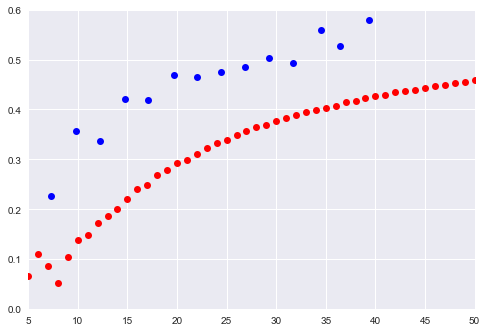

In [1182]:
f1 = 25250
f2 = 25000
s1 = 25.2
s2 = 25.0

pl.plot(trimdata[(trimdata['frequency'] == f1)& (trimdata['viscosity'] == 0.0)& (trimdata['size'] == s1)]['field'], \
        trimdata[(trimdata['frequency'] == f1)& (trimdata['viscosity'] == 0.0)& (trimdata['size'] == s1)]['5:3'], \
        marker = "o", linestyle="none", c="b")
#pl.plot(trimdata[(trimdata['frequency'] == f1)& (trimdata['mannitol'] == 11.0)& (trimdata['size'] == s1)]['field'], \
#        trimdata[(trimdata['frequency'] == f1)& (trimdata['mannitol'] == 11.0)& (trimdata['size'] == s1)]['5:3'], \
#        marker = "o", linestyle="none", c="c")
#pl.plot(trimdata[(trimdata['frequency'] == 40200)& (trimdata['viscosity'] == 0.0)& (trimdata['size'] == 27.7)]['field'], \
#        trimdata[(trimdata['frequency'] == 40200)& (trimdata['viscosity'] == 0.0)& (trimdata['size'] == 27.7)]['D5:3'], \
#        marker = "o", linestyle="none", c="g")
pl.plot(sdata[(sdata['frequency'] == f2)& (sdata['K'] == 2500)& (sdata['size'] == s2)]['field'], \
        sdata[(sdata['frequency'] == f2)& (sdata['K'] == 2500)& (sdata['size'] == s2)]['5:3'], \
        marker = "o", linestyle="none", c="r")
#pl.plot(sdata[(sdata['frequency'] == f2)& (sdata['b'] == "off")& (sdata['size'] == s2)]['field'], \
#        sdata[(sdata['frequency'] == f2)& (sdata['b'] == "off")& (sdata['size'] == s2)]['5:3'], \
#        marker = "o", linestyle="none", c="c")
pl.ylim(0,0.6)
pl.xlim(5,50)
pl.show()

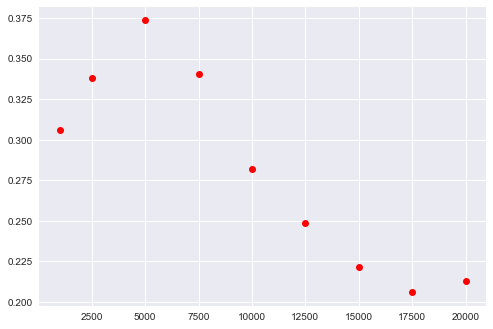

In [1190]:
pl.plot(sdata[(sdata['frequency'] == f2)& (sdata['b'] == "on")& (sdata['size'] == 30.0)& (sdata['field'] == 20.0)]['K'], \
        sdata[(sdata['frequency'] == f2)& (sdata['b'] == "on")& (sdata['size'] == 30.0)& (sdata['field'] == 20.0)]['5:3'], \
        marker = "o", linestyle="none", c="r")
pl.show()

# fitting

In [1052]:
def func(ratio, omega, h, tau, A, B, beta):
    return ratio*(1 + (A*(h/temp)**B)*(omega*tau)**beta)**(-1)

def func1(ratio, h, gamma, alpha):
    return ratio*(1 + gamma*h**alpha)**(-1)

def func2(ratio, omega, h, gamma, beta):
    return ratio*(1 + (omega**beta)*gamma*(h**.87))**(-1)

def func3(ratio, h, gamma, alpha, A, B):
    return ratio*(1 + gamma*h**alpha*(1 + A*h**B)**(-0.5))**(-1)

def func4(ratio, h, gamma, A, B):
    return ratio*(1 + gamma*(1 + A*h**B)**(-0.5))**(-1)

def func5(ratio, h, beta, gamma, A, B):
    return ratio*(1 + gamma*(1 + A*h**B)**(-beta/2.))**(-1)

def func6(ratio, h, alpha, beta, gamma, A, B):
    return ratio*(1 + h**alpha*gamma*(1 + A*h**B)**(-beta/2.))**(-1)

def func7(ratio, h, gamma):
    return ratio*(1 + gamma*(1 + 0.126*h**1.72)**(-1.85/2.))**(-1)

def func8(ratio, h, v, gamma, A, B):
    return ratio*(1 + gamma*(1 + A*(Ms*v*h/(kb*temp))**B)**(-1.85/2.))**(-1)

def func9(ratio, h, v, omega, gamma, A, B, ms):
    return ratio*(1 + gamma*(omega)**1.85*(1 + A*(ms*v*h/(kb*temp))**B)**(-1.85/2.))**(-1)

#def func10(ratio, h, v, omega, tau, gamma, A, B):
#    return ratio*(1 + gamma*(omega*tau)**1.85*(1 + A*(Ms*v*h/(kb*temp))**B)**(-1.85/2.))**(-1)

def func10(ratio, h, v, omega, tauB, tauN, gamma, A, B, eps):
    return ratio*(1 + gamma*(omega*tauB*tauN/(tauB+eps*tauN))**1.85*(1 + A*(Ms*v*h/(kb*temp))**B)**(-1.85/2.))**(-1)

def func11(ratio, h, v, omega, tauB, tauN, gamma):
    xi = Ms*v*h/(kb*temp)
    tauNH = tauN/np.sqrt(1 + 1.97*xi**3.18)
    tauBH = tauB/np.sqrt(1 + .126*xi**1.72)
    tauE = tauNH*tauBH/(tauNH + tauBH/h)
    return ratio*(1 + gamma*(omega*tauE)**1.85)**(-1)

### test

{'gamma': 432.12991303143656}
0.00320862152643


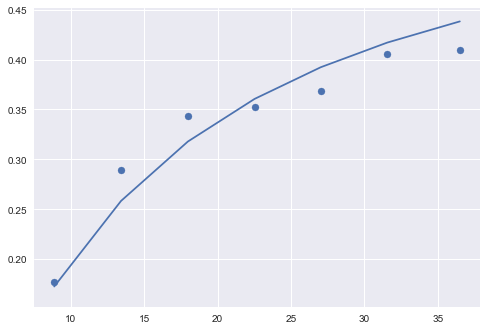

In [883]:
model = Model(func, independent_vars=['ratio','omega','h'])
model1 = Model(func1, independent_vars=['ratio','h'])
model2 = Model(func2, independent_vars=['ratio','omega','h'])
model3 = Model(func3, independent_vars=['ratio','h'])
model4 = Model(func4, independent_vars=['ratio','h'])
model5 = Model(func5, independent_vars=['ratio','h'])
model6 = Model(func6, independent_vars=['ratio','h'])
model7 = Model(func7, independent_vars=['ratio','h'])
model8 = Model(func8, independent_vars=['ratio','h', 'v'])
model9 = Model(func9, independent_vars=['ratio','h', 'omega','v', 'ms'])
model10 = Model(func10, independent_vars=['ratio','h', 'omega','v', 'tauB', 'tauN'])
model11 = Model(func11, independent_vars=['ratio','h', 'omega','v', 'tauB', 'tauN'])

cutdata = trimdata[(trimdata['size'] == 25.2) & (trimdata['viscosity'] == 4.0) \
                   & (trimdata['frequency'] == 40200)& (trimdata['field'] > 3)]

model1.set_param_hint('gamma', min=0)
model1.set_param_hint('alpha', min=1e-2, max=10)

model2.set_param_hint('gamma', min=0)
model2.set_param_hint('beta', min=1e-1, max=10)

model3.set_param_hint('gamma', min=0)
model3.set_param_hint('alpha', min=1e-2, max=10)
model3.set_param_hint('A', min=0)
model3.set_param_hint('B', min=1e-2, max=10)

model4.set_param_hint('gamma', min=0)
model4.set_param_hint('A', min=0)
model4.set_param_hint('B', min=1e-2, max=10)

model5.set_param_hint('gamma', min=0)
model5.set_param_hint('beta', min=1e-2, max=1.85)
model5.set_param_hint('A', min=0)
model5.set_param_hint('B', min=1e-2, max=10)

model6.set_param_hint('gamma', min=0)
model6.set_param_hint('beta', min=1e-2, max=10)
model6.set_param_hint('alpha', min=0, max=10)
model6.set_param_hint('A', min=0, max=100)
model6.set_param_hint('B', min=1e-2, max=10)

model7.set_param_hint('gamma', min=0)

model8.set_param_hint('gamma', min=0)
model8.set_param_hint('A', min=0)
model8.set_param_hint('B', min=0, max=10)

model9.set_param_hint('gamma', min=0)
model9.set_param_hint('A', min=0)
model9.set_param_hint('B', min=0, max=10)

model10.set_param_hint('gamma', min=0)
model10.set_param_hint('A', min=0)
model10.set_param_hint('B', min=0)
model10.set_param_hint('eps', min=0, max=1)
#model10.set_param_hint('alpha', min=0)

model11.set_param_hint('gamma', min=0)

result = model11.fit(cutdata['5:3'], ratio=cutdata['L5:3'], h=0.001*cutdata['field'], v = cutdata['Vc'], omega = cutdata['angF'], \
                    tauN = cutdata['tauN'],tauB = cutdata['tauB'], gamma=1, nan_policy='omit', method='leastsq')

print(result.values)
print(result.chisqr)

#print("A':")
#print(result.params['A'].value/(mu0*420000.*np.pi*(25.2e-9)**3/(6*kb*temp))**3.68)

cutdata = cutdata.sort_values(by=['field'])
scatter(cutdata['field'], cutdata['5:3'])
plot(cutdata['field'], func11(ratio=cutdata['L5:3'],h=0.001*cutdata['field'], v = cutdata['Vc'], omega=cutdata['angF'],tauN = cutdata['tauN'],tauB = cutdata['tauB'],**result.values))

show()


## Simulation fitting

{'gamma': 9.9035281819759291e-07, 'A': 2669.2800429548965, 'B': 1.1370069311612772}
0.0171917736618


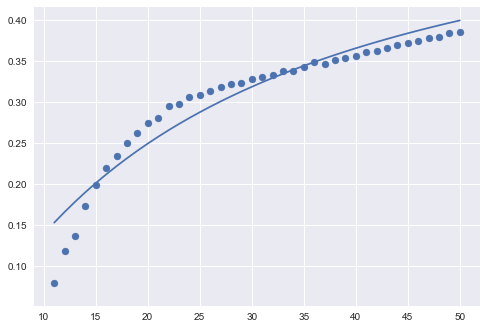

In [1158]:
model9 = Model(func9, independent_vars=['ratio','h', 'omega','v','ms'])
model11 = Model(func11, independent_vars=['ratio','h', 'omega','v', 'tauB', 'tauN'])

cutdata = sdata[(sdata['size'] == 30.0) & (sdata['b'] == "off") \
                   & (sdata['frequency'] == 100000) & (sdata['field'] > 10)]

cutdata.is_copy = True
#cutdata['5:3'] = [ x + .2 for x in cutdata['5:3'] ]

model9.set_param_hint('gamma', min=0)
model9.set_param_hint('A', min=0)
model9.set_param_hint('B', min=0, max=5)

model11.set_param_hint('gamma', min=0)

result = model9.fit(cutdata['5:3'], ratio=cutdata['L5:3'], h=0.001*cutdata['field'], v = cutdata['Vc'], omega = cutdata['angF'], ms = cutdata['Ms'],\
                     gamma=1e-6, A=1, B=1, nan_policy='omit', method='leastsq')
#result = model11.fit(cutdata['5:3'], ratio=cutdata['L5:3'], h=0.001*cutdata['field'], v = cutdata['Vc'], omega = cutdata['angF'], \
#                    tauN = cutdata['tauN'],tauB = cutdata['tauB'], gamma=1, nan_policy='omit', method='leastsq')

print(result.values)
print(result.chisqr)

cutdata = cutdata.sort_values(by=['field'])
scatter(cutdata['field'], cutdata['5:3'])
#plot(cutdata['field'], func11(ratio=cutdata['L5:3'],h=0.001*cutdata['field'], v = cutdata['Vc'], omega=cutdata['angF'],tauN = cutdata['tauN'],tauB = cutdata['tauB'],**result.values))
plot(cutdata['field'], func9(ratio=cutdata['L5:3'],h=0.001*cutdata['field'], v = cutdata['Vc'], omega=cutdata['angF'],ms = cutdata['Ms'],**result.values))
show()

## best fits to f9

Want A, B ~ 1. Gamma includes tau

### 27nm

{'gamma': 0.00059704040198882424, 'A': 876.85396202148252, 'B': 4.3298944116695104}
0.00328420344809


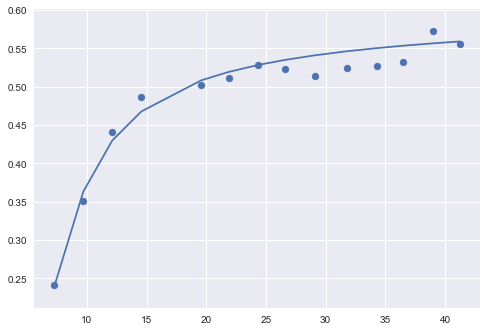

In [1074]:
model9 = Model(func9, independent_vars=['ratio','h', 'omega','v', 'ms'])

cutdata = trimdata[(trimdata['size'] == 27.7) & (trimdata['viscosity'] == 0.0) \
                   & (trimdata['frequency'] == 15500)& (trimdata['field'] < 43)]

model9.set_param_hint('gamma', min=0)
model9.set_param_hint('A', min=0)
model9.set_param_hint('B', min=1.72, max=8)

result = model9.fit(cutdata['5:3'], ratio=cutdata['L5:3'], h=0.001*cutdata['field'], v = cutdata['Vc'], omega = cutdata['angF'], ms = cutdata['Ms'],\
                     gamma=1e-3, A=1, B=2, nan_policy='omit', method='leastsq')

print(result.values)
print(result.chisqr)

cutdata = cutdata.sort_values(by=['field'])
scatter(cutdata['field'], cutdata['5:3'])
plot(cutdata['field'], func9(ratio=cutdata['L5:3'],h=0.001*cutdata['field'], v = cutdata['Vc'], omega=cutdata['angF'],ms = cutdata['Ms'],**result.values))

show()

{'gamma': 2.3319556030632071e-06, 'A': 1186.2254375259706, 'B': 1.6975572735881732}
0.00751602986123


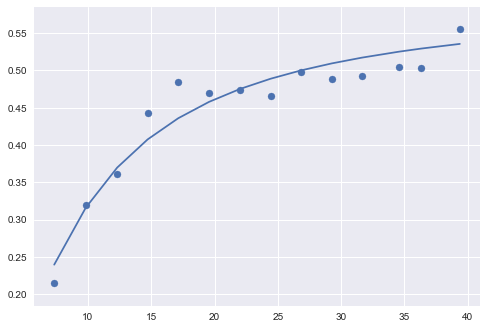

In [1075]:
model9 = Model(func9, independent_vars=['ratio','h', 'omega','v','ms'])

cutdata = trimdata[(trimdata['size'] == 27.7) & (trimdata['viscosity'] == 0.0) \
                   & (trimdata['frequency'] == 25250)]

model9.set_param_hint('gamma', min=0)
model9.set_param_hint('A', min=0)
model9.set_param_hint('B', min=0, max=10)

result = model9.fit(cutdata['5:3'], ratio=cutdata['L5:3'], h=0.001*cutdata['field'], v = cutdata['Vc'], omega = cutdata['angF'],ms = cutdata['Ms'], \
                    gamma=1e-6, A=1, B=1, nan_policy='omit', method='leastsq')

print(result.values)
print(result.chisqr)

cutdata = cutdata.sort_values(by=['field'])
scatter(cutdata['field'], cutdata['5:3'])
plot(cutdata['field'], func9(ratio=cutdata['L5:3'],h=0.001*cutdata['field'], v = cutdata['Vc'], omega=cutdata['angF'],ms = cutdata['Ms'],**result.values))

show()

{'gamma': 6.3826029832458886e-06, 'A': 2522.2799903227374, 'B': 1.6706338420349369}
0.00132221164185


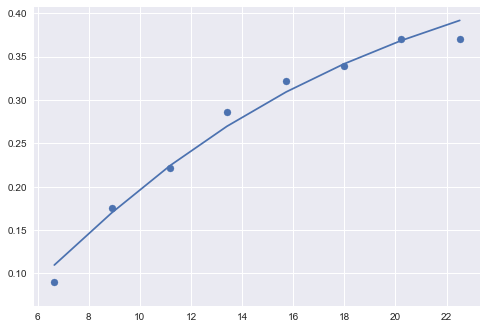

In [1076]:
model9 = Model(func9, independent_vars=['ratio','h', 'omega','v','ms'])

cutdata = trimdata[(trimdata['size'] == 27.7) & (trimdata['viscosity'] == 0.0) \
                   & (trimdata['frequency'] == 40200) & (trimdata['field'] < 23)]

model9.set_param_hint('gamma', min=0)
model9.set_param_hint('A', min=0)
model9.set_param_hint('B', min=0, max=10)

result = model9.fit(cutdata['5:3'], ratio=cutdata['L5:3'], h=0.001*cutdata['field'], v = cutdata['Vc'], omega = cutdata['angF'],ms = cutdata['Ms'], \
                    gamma=1e-6, A=1, B=1, nan_policy='omit', method='leastsq')

print(result.values)
print(result.chisqr)

cutdata = cutdata.sort_values(by=['field'])
scatter(cutdata['field'], cutdata['5:3'])
plot(cutdata['field'], func9(ratio=cutdata['L5:3'],h=0.001*cutdata['field'], v = cutdata['Vc'], omega=cutdata['angF'],ms = cutdata['Ms'],**result.values))

show()

### 25nm

{'gamma': 6.3275423123343444e-08, 'A': 1009.3239714524663, 'B': 9.9992134009659761}
0.00613730969454


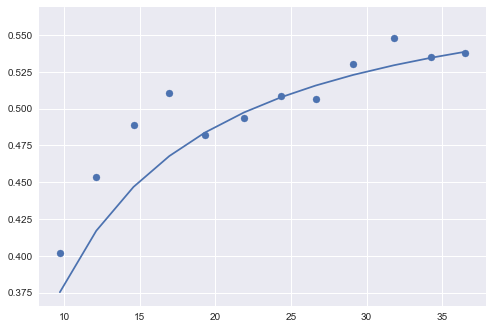

In [1077]:
model9 = Model(func9, independent_vars=['ratio','h', 'omega','v','ms'])

cutdata = trimdata[(trimdata['size'] == 25.2) & (trimdata['viscosity'] == 0.0) \
                   & (trimdata['frequency'] == 15500) & (trimdata['field'] > 8)& (trimdata['field'] < 37)]

model9.set_param_hint('gamma', min=0)
model9.set_param_hint('A', min=0)
model9.set_param_hint('B', min=0, max=10)

result = model9.fit(cutdata['5:3'], ratio=cutdata['L5:3'], h=0.001*cutdata['field'], v = cutdata['Vc'], omega = cutdata['angF'], ms = cutdata['Ms'],\
                     gamma=1e-3, A=1, B=1, nan_policy='omit', method='leastsq')

print(result.values)
print(result.chisqr)

cutdata = cutdata.sort_values(by=['field'])
scatter(cutdata['field'], cutdata['5:3'])
plot(cutdata['field'], func9(ratio=cutdata['L5:3'],h=0.001*cutdata['field'], v = cutdata['Vc'], omega=cutdata['angF'],ms = cutdata['Ms'],**result.values))

show()

{'gamma': 2.9004529356058129e-07, 'A': 311.77203021647205, 'B': 1.8629267988841351}
0.00787842813885


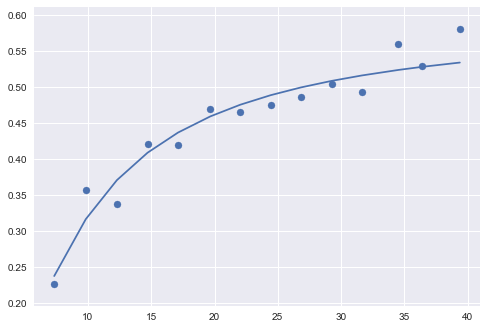

In [1078]:
model9 = Model(func9, independent_vars=['ratio','h', 'omega','v','ms'])

cutdata = trimdata[(trimdata['size'] == 25.2) & (trimdata['viscosity'] == 0.0) \
                   & (trimdata['frequency'] == 25250) & (trimdata['field'] > 3)]

model9.set_param_hint('gamma', min=0)
model9.set_param_hint('A', min=0)
model9.set_param_hint('B', min=0, max=5)

result = model9.fit(cutdata['5:3'], ratio=cutdata['L5:3'], h=0.001*cutdata['field'], v = cutdata['Vc'], omega = cutdata['angF'], ms = cutdata['Ms'],\
                     gamma=1e-6, A=1, B=1, nan_policy='omit', method='leastsq')

print(result.values)
print(result.chisqr)

cutdata = cutdata.sort_values(by=['field'])
scatter(cutdata['field'], cutdata['5:3'])
plot(cutdata['field'], func9(ratio=cutdata['L5:3'],h=0.001*cutdata['field'], v = cutdata['Vc'], omega=cutdata['angF'],ms = cutdata['Ms'],**result.values))

show()

{'gamma': 2.6766456406868144e-07, 'A': 1280.1474692795484, 'B': 0.83189991030388821}
0.00157568067197


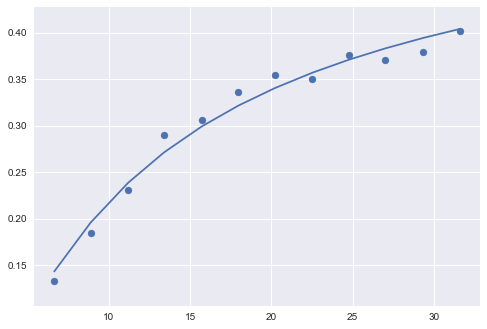

In [1079]:
model9 = Model(func9, independent_vars=['ratio','h', 'omega','v','ms'])

cutdata = trimdata[(trimdata['size'] == 25.2) & (trimdata['viscosity'] == 0.0) \
                   & (trimdata['frequency'] == 40200) & (trimdata['field'] < 33)]

model9.set_param_hint('gamma', min=0)
model9.set_param_hint('A', min=0)
model9.set_param_hint('B', min=0, max=5)

result = model9.fit(cutdata['5:3'], ratio=cutdata['L5:3'], h=0.001*cutdata['field'], v = cutdata['Vc'], omega = cutdata['angF'],ms = cutdata['Ms'], \
                     gamma=1e-6, A=1, B=1, nan_policy='omit', method='leastsq')

print(result.values)
print(result.chisqr)

cutdata = cutdata.sort_values(by=['field'])
scatter(cutdata['field'], cutdata['5:3'])
plot(cutdata['field'], func9(ratio=cutdata['L5:3'],h=0.001*cutdata['field'], v = cutdata['Vc'], omega=cutdata['angF'],ms = cutdata['Ms'],**result.values))

show()

### 22nm

{'gamma': 7.7222539474064433e-10, 'A': 944.3889824732895, 'B': 4.999999997003461}
0.0278451550604


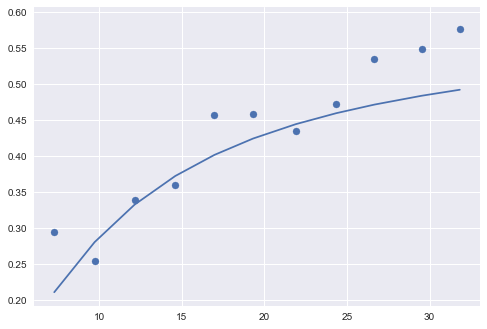

In [1080]:
model9 = Model(func9, independent_vars=['ratio','h', 'omega','v','ms'])

cutdata = trimdata[(trimdata['size'] == 21.9) & (trimdata['viscosity'] == 0.0) \
                   & (trimdata['frequency'] == 15500) & (trimdata['field'] < 33)]

model9.set_param_hint('gamma', min=0)
model9.set_param_hint('A', min=0)
model9.set_param_hint('B', min=0, max=5)

result = model9.fit(cutdata['5:3'], ratio=cutdata['L5:3'], h=0.001*cutdata['field'], v = cutdata['Vc'], omega = cutdata['angF'],ms = cutdata['Ms'], \
                     gamma=1e-6, A=1, B=1, nan_policy='omit', method='leastsq')

print(result.values)
print(result.chisqr)

cutdata = cutdata.sort_values(by=['field'])
scatter(cutdata['field'], cutdata['5:3'])
plot(cutdata['field'], func9(ratio=cutdata['L5:3'],h=0.001*cutdata['field'], v = cutdata['Vc'], omega=cutdata['angF'],ms = cutdata['Ms'],**result.values))

show()

{'gamma': 1.000000082740371e-09, 'A': 0.05104438130697897, 'B': 4.0637662425818606}
0.00357383058136


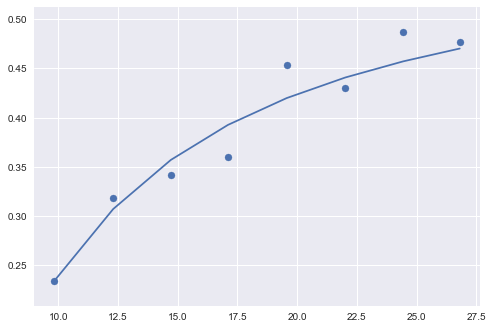

In [1081]:
model9 = Model(func9, independent_vars=['ratio','h', 'omega','v','ms'])

cutdata = trimdata[(trimdata['size'] == 21.9) & (trimdata['viscosity'] == 0.0) \
                   & (trimdata['frequency'] == 25250) & (trimdata['field'] < 28)]

model9.set_param_hint('gamma', min=0)
model9.set_param_hint('A', min=0)
model9.set_param_hint('B', min=0)

result = model9.fit(cutdata['5:3'], ratio=cutdata['L5:3'], h=0.001*cutdata['field'], v = cutdata['Vc'], omega = cutdata['angF'], ms = cutdata['Ms'],\
                     gamma=1e-9, A=1, B=1, nan_policy='omit', method='leastsq')

print(result.values)
print(result.chisqr)

cutdata = cutdata.sort_values(by=['field'])
scatter(cutdata['field'], cutdata['5:3'])
plot(cutdata['field'], func9(ratio=cutdata['L5:3'],h=0.001*cutdata['field'], v = cutdata['Vc'], omega=cutdata['angF'],ms = cutdata['Ms'],**result.values))

show()

{'gamma': 1.000000082740371e-09, 'A': 0.099224891098941725, 'B': 2.6635925984665318}
0.00240813282031


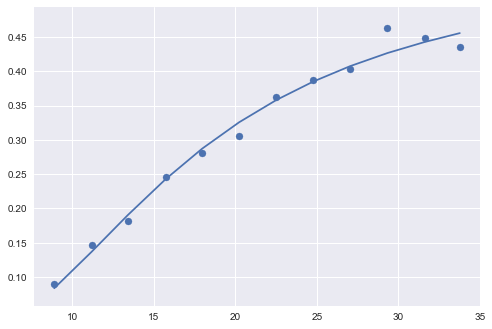

In [1082]:
model9 = Model(func9, independent_vars=['ratio','h', 'omega','v','ms'])

cutdata = trimdata[(trimdata['size'] == 21.9) & (trimdata['viscosity'] == 0.0) \
                   & (trimdata['frequency'] == 40200) & (trimdata['field'] > 3)]

model9.set_param_hint('gamma', min=0)
model9.set_param_hint('A', min=0)
model9.set_param_hint('B', min=0)

result = model9.fit(cutdata['5:3'], ratio=cutdata['L5:3'], h=0.001*cutdata['field'], v = cutdata['Vc'], omega = cutdata['angF'],ms = cutdata['Ms'], \
                     gamma=1e-9, A=1, B=1, nan_policy='omit', method='leastsq')

print(result.values)
print(result.chisqr)

cutdata = cutdata.sort_values(by=['field'])
scatter(cutdata['field'], cutdata['5:3'])
plot(cutdata['field'], func9(ratio=cutdata['L5:3'],h=0.001*cutdata['field'], v = cutdata['Vc'], omega=cutdata['angF'],ms = cutdata['Ms'],**result.values))

show()

# ML fitting

[[  8.98198732e-03  -4.86460339e-06  -1.41089018e-04  -4.94153584e-04]]


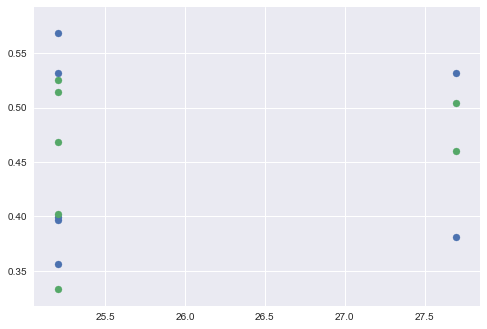

In [189]:
mldata = trimdata[trimdata['label'] == "g"]
num = 490
X = mldata[:num][['field','frequency','size','viscosity']]
Y = mldata[:num][['5:3']]
X_train, X_test , y_train , y_test = train_test_split(X,Y,test_size=0.15,random_state=26)
model = LinearRegression()
model.fit(X, Y)
predictions=model.predict(mldata[num:][['field','frequency','size','viscosity']])
print(model.coef_)
scatter(mldata[num:][['size']],predictions)
scatter(mldata[num:][['size']],mldata[num:][['5:3']])
show()

